In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress all warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Import our project modules
from challenge.data.ingest import load_data
from challenge.data.feature_selection import select_features_ks, split_histogram_features, engineer_histogram_features, create_engineered_feature_set
from challenge.modelling.train_eval import cv_cost, evaluate_on_test
from challenge.visualization.performance_viz import plot_confusion, plot_cost_threshold_curve
# Import ML models and tools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import warnings
from sklearn.exceptions import ConvergenceWarning

# Configure plotting
%matplotlib inline
sns.set_theme(style="whitegrid")


In [3]:
# --- Configuration ---
DATA_PATH = 'dataset/' # Or './dataset/' which means the same thing
TRAIN_FILE = 'aps_failure_training_set.csv'
TEST_FILE = 'aps_failure_test_set.csv'

In [4]:
# Load raw data
X_train_raw, y_train_raw = load_data(DATA_PATH, TRAIN_FILE)
X_test_raw, y_test_raw = load_data(DATA_PATH, TEST_FILE)

print(f"Raw train shape: {X_train_raw.shape}")
print(f"Raw test shape: {X_test_raw.shape}")

Successfully loaded and processed aps_failure_training_set.csv. X shape: (60000, 170), y shape: (60000,)
Successfully loaded and processed aps_failure_test_set.csv. X shape: (16000, 170), y shape: (16000,)
Raw train shape: (60000, 170)
Raw test shape: (16000, 170)


In [5]:
# This is a data-cleaning step applied *only* to the training set.

print(f"Original train shape (X, y): {X_train_raw.shape}, {y_train_raw.shape}")

# 1. Find columns with low missingness (0% < NA <= 4%)
na_pct = X_train_raw.isna().mean()
low_na_cols = na_pct[(na_pct > 0) & (na_pct <= 0.04)].index

if not low_na_cols.empty:
    # 2. Find the indices of rows that have *any* NaN in these specific columns
    rows_to_drop = X_train_raw[low_na_cols].isna().any(axis=1)
    
    # 3. Get the indices to drop
    drop_indices = X_train_raw[rows_to_drop].index
    
    # 4. Drop these rows from *both* X_train and y_train
    X_train_raw = X_train_raw.drop(index=drop_indices)
    y_train_raw = y_train_raw.drop(index=drop_indices)
    
    print(f"Identified {len(low_na_cols)} low-NA columns.")
    print(f"Dropped {len(drop_indices)} rows from training set.")
else:
    print("No low-NA columns found. No rows dropped.")

print(f"Cleaned train shape (X, y): {X_train_raw.shape}, {y_train_raw.shape}")
print(f"Test set shape remains: {X_test_raw.shape}, {y_test_raw.shape}")

Original train shape (X, y): (60000, 170), (60000,)
Identified 99 low-NA columns.
Dropped 1873 rows from training set.
Cleaned train shape (X, y): (58127, 170), (58127,)
Test set shape remains: (16000, 170), (16000,)


In [6]:
from challenge.data.feature_selection import select_features_mutual_info
# Pre-compute the K-S selected feature list
# We do this once, outside the loop.
print("--- Computing Kolmogorov Smirnoff Feature Set ---")
print("\n--- Selecting top 135 features ---")
# Use a permissive p-value, we know from EDA it's fine
selected_features = select_features_ks(X_train_raw, y_train_raw, top_n_by_stat=135, p_value_threshold=0.05)

# Create the filtered DataFrames
X_train_ks = X_train_raw[selected_features]
X_test_ks = X_test_raw[selected_features]

print(f"\nK-S Filtered train shape: {X_train_ks.shape}")


print("\n--- Computing Engineered Feature Set ---")
print(" Instead of using the raw histogram bins, we will use the engineered features.")
# Apply the stateless transformation to both train and test
X_train_eng = create_engineered_feature_set(X_train_raw)
X_test_eng = create_engineered_feature_set(X_test_raw)

print("\n--- Computing Mutual Information Feature Set ---")
print("\n--- Selecting top 135 features ---")
# Select top 70 features by Mutual Information
selected_feature_mi = select_features_mutual_info(X_train_raw, y_train_raw, top_n=135)
X_train_mi = X_train_raw[selected_feature_mi]
X_test_mi = X_test_raw[selected_feature_mi]

print(f"\nMI Filtered train shape: {X_train_mi.shape}")
print(f"MI Filtered test shape: {X_test_mi.shape}")


--- Computing Kolmogorov Smirnoff Feature Set ---

--- Selecting top 135 features ---
Starting K-S test on 170 features...

K-S Filtered train shape: (58127, 135)

--- Computing Engineered Feature Set ---
 Instead of using the raw histogram bins, we will use the engineered features.
Identified 7 histogram families.
Calculating stats for 7 groups...
Replaced 70 hist bins with 35 engineered features.
Original feature count: 170 -> New engineered feature count: 135
Identified 7 histogram families.
Calculating stats for 7 groups...
Replaced 70 hist bins with 35 engineered features.
Original feature count: 170 -> New engineered feature count: 135

--- Computing Mutual Information Feature Set ---

--- Selecting top 135 features ---
Calculating Mutual Information...
Selected top 135 features by Mutual Information.

MI Filtered train shape: (58127, 135)
MI Filtered test shape: (16000, 135)


In [7]:
# In cell "1. Experiment Configuration"

# --- NEW: Define your feature sets to test ---
# This dictionary maps a name to the prepared DataFrames
FEATURE_SETS_TO_TEST = {
    #"All": (X_train_raw, X_test_raw),
    "K-S Selected": (X_train_ks, X_test_ks),
    #"Engineered": (X_train_eng, X_test_eng),
    "Mutual Information": (X_train_mi, X_test_mi)
}

# --- NEW: Define your samplers to test ---
SAMPLERS_TO_TEST = {
    "No Sampling": None,
    "SMOTE": "smote",
    "Gaussian Copula": "copula"
}

# --- NEW: Define your tuning strategies to test ---
TUNING_STRATEGIES_TO_TEST = {
    "Tuned Threshold": True,
    #"Fixed 0.5 Threshold": False
}

SAMPLING_PERCENTAGES_TO_TEST = [0.25,0.5,0.75]
MODELS_TO_TEST = {
    # 'LightGBM Balanced': LGBMClassifier(
    #    random_state=42,
    #    class_weight='balanced',
    #),
    #'LogisticRegression': LogisticRegression(
    #    random_state=42, 
    #    class_weight='balanced', 
    #    solver='liblinear',  
    #    C=1.0,               
    #    max_iter=1000
    #),
    #'RandomForest': RandomForestClassifier(
    #    n_estimators=100, 
    #    random_state=42, 
    #    class_weight='balanced'
    #),
    'LightGBM Default': LGBMClassifier(
        random_state=42
    )
}

N_CV_SPLITS = 4


In [8]:
results_list = []
print("--- STARTING EXPERIMENT MATRIX ---")
# Outer loop: Iterate over models
for model_name, model_obj in MODELS_TO_TEST.items():
    for fset_name, (X_train_data, _) in FEATURE_SETS_TO_TEST.items():
        for sampler_name, sampler_key in SAMPLERS_TO_TEST.items():
            if sampler_name !='No Sampling':   
                for sampling_percentage in SAMPLING_PERCENTAGES_TO_TEST:
                    for tuning_name, tuning_bool in TUNING_STRATEGIES_TO_TEST.items():
                        run_name = f"{model_name} | {fset_name} | {sampler_name} | {tuning_name} | {sampling_percentage}"
                        print(f"\n=====================================")
                        print(f"RUNNING: {run_name}")
                        print(f"=====================================")
                        model = deepcopy(model_obj)
                    
                        # Run Cross-Validation
                        cv_results = cv_cost(
                            model,
                            X_train_data,
                            y_train_raw,
                            sampler=sampler_key,
                            tune_threshold=tuning_bool,
                            folds=N_CV_SPLITS,
                            show_progress=True,
                            verbose=True,
                            sampling_strategy=sampling_percentage,
                            random_state=42,
                        )
                        
                        # Store results
                        results_list.append({
                            'model': model_name,
                            'feature_set': fset_name,
                            'sampler': sampler_name,
                            'tuning': tuning_name,
                            'cost_mean': cv_results['Cost_mean'],
                            'cost_std': cv_results['Cost_std'],
                            'auc_mean': cv_results['AUC_mean'],
                            'f1_mean': cv_results['F1_mean'],
                            'fit_time_mean': cv_results['fit_time_mean'],
                            'sampling_percentage': sampling_percentage,
                            'run_name': run_name
                        })
            else: 
                for tuning_name, tuning_bool in TUNING_STRATEGIES_TO_TEST.items():
                    run_name = f"{model_name} | {fset_name} | {sampler_name} | {tuning_name}"
                    print(f"\n=====================================")
                    print(f"RUNNING: {run_name}")
                    print(f"=====================================")
                    model = deepcopy(model_obj)
                    
                    # Run Cross-Validation
                    cv_results = cv_cost(
                        model,
                        X_train_data,
                        y_train_raw,
                        sampler=sampler_key,
                        tune_threshold=tuning_bool,
                        folds=N_CV_SPLITS,
                        show_progress=True,
                        verbose=True,
                        random_state=42,
                    )
                    
                    # Store results
                    results_list.append({
                        'model': model_name,
                        'feature_set': fset_name,
                        'sampler': sampler_name,
                        'tuning': tuning_name,
                        'cost_mean': cv_results['Cost_mean'],
                        'cost_std': cv_results['Cost_std'],
                        'auc_mean': cv_results['AUC_mean'],
                        'f1_mean': cv_results['F1_mean'],
                        'fit_time_mean': cv_results['fit_time_mean'],
                        'run_name': run_name
                    })


print("\n--- EXPERIMENT MATRIX COMPLETE ---")
# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results_list)
print("\n--- EXPERIMENT MATRIX COMPLETE ---")

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results_list)

--- STARTING EXPERIMENT MATRIX ---

RUNNING: LightGBM Default | K-S Selected | No Sampling | Tuned Threshold
Running 4-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[LightGBM] [Info] Number of positive: 696, number of negative: 42899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33106
[LightGBM] [Info] Number of data points in the train set: 43595, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015965 -> initscore=-4.121254
[LightGBM] [Info] Start training from score -4.121254
[LightGBM] [Info] Number of positive: 697, number of negative: 42898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33107
[LightGBM] [Info] Number of data points in the train set: 43595, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015988 -> initscore=-4.119795
[LightGBM] [Info] Start training from score -4.119795
[LightGBM] [

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10724, number of negative: 42898
[LightGBM] [Info] Number of positive: 10724, number of negative: 42899
[LightGBM] [Info] Number of positive: 10724, number of negative: 42899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33405
[LightGBM] [Info] Number of data points in the train set: 53623, number of used features: 131
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199989 -> initscore=-1.386364
[LightGBM] [Info] Start training from score -1.386364
[LightGBM] [Info] Total Bins 33405
[LightGBM] [Info] Number of data points in the train set: 53622, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199993 -> initscore=-

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10724, number of negative: 42898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33405
[LightGBM] [Info] Number of data points in the train set: 53622, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199993 -> initscore=-1.386341
[LightGBM] [Info] Start training from score -1.386341
AUC 0.990±0.004 | Macro-F1 0.743 | Cost 8412±1044 | thr(median) 0.015812824169347435 | fit 6.83s | pred 0.04s

RUNNING: LightGBM Default | K-S Selected | SMOTE | Tuned Threshold | 0.5
Running 4-fold CV with n_jobs=-1...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[LightGBM] [Info] Number of positive: 21449, number of negative: 42899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33405
[LightGBM] [Info] Number of data points in the train set: 64348, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333328 -> initscore=-0.693170
[LightGBM] [Info] Start training from score -0.693170
[LightGBM] [Info] Number of positive: 21449, number of negative: 42899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33405
[LightGBM] [Info] Number of data points in the train set: 64348, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333328 -> initscore=-0.693170
[LightGBM] [Info] Start training from score -0.693170


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[LightGBM] [Info] Number of positive: 21449, number of negative: 42898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33405
[LightGBM] [Info] Number of data points in the train set: 64347, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Number of positive: 21449, number of negative: 42898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33405
[LightGBM] [Info] Number of data points in the train set: 64347, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
AUC 0.99

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[LightGBM] [Info] Number of positive: 32173, number of negative: 42898
[LightGBM] [Info] Number of positive: 32174, number of negative: 42899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of positive: 32173, number of negative: 42898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33405
[LightGBM] [Info] Total Bins 33405
[LightGBM] [Info] Number of data points in the train set: 75073, number of used features: 131
[LightGBM] [Info] Number of data points in the train set: 75071, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428570 -> initscore=-0.2876

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 697 minority, 42898 majority.
Target ratio: 0.25 -> Target minority count: 10724
Synthesizing 10027 samples...
Balancing: 697 minority, 42898 majority.
Target ratio: 0.25 -> Target minority count: 10724
Synthesizing 10027 samples...
Balancing: 696 minority, 42899 majority.
Target ratio: 0.25 -> Target minority count: 10724
Synthesizing 10028 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing: 697 minority, 42899 majority.
Target ratio: 0.25 -> Target minority count: 10724
Synthesizing 10027 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing complete. New dataset size: 53622
Balancing complete. New dataset size: 53623
Balancing complete. New dataset size: 53622
[LightGBM] [Info] Number of positive: 10724, number of negative: 42898
[LightGBM] [Info] Number of positive: 10724, number of negative: 42899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33345
[LightGBM] [Info] Number of data points in the train set: 53622, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199993 -> initscore=-1.386341
[LightGBM] [Info] Start training from score -1.386341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33334
[LightGBM] [Info] Number of data points in the train set: 53623, number of used features: 131
[LightGBM]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 696 minority, 42899 majority.
Target ratio: 0.5 -> Target minority count: 21449
Synthesizing 20753 samples...
Balancing: 697 minority, 42898 majority.
Target ratio: 0.5 -> Target minority count: 21449
Synthesizing 20752 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 697 minority, 42898 majority.
Target ratio: 0.5 -> Target minority count: 21449
Synthesizing 20752 samples...
Balancing: 697 minority, 42899 majority.
Target ratio: 0.5 -> Target minority count: 21449
Synthesizing 20752 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing complete. New dataset size: 64348
Balancing complete. New dataset size: 64347
Balancing complete. New dataset size: 64347
Balancing complete. New dataset size: 64348
[LightGBM] [Info] Number of positive: 21449, number of negative: 42899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33345
[LightGBM] [Info] Number of data points in the train set: 64348, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333328 -> initscore=-0.693170
[LightGBM] [Info] Start training from score -0.693170
[LightGBM] [Info] Number of positive: 21449, number of negative: 42898
[LightGBM] [Info] Number of positive: 21449, number of negative: 42898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010116 seconds.
You can set `force

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 696 minority, 42899 majority.
Target ratio: 0.75 -> Target minority count: 32174
Synthesizing 31478 samples...
Balancing: 697 minority, 42898 majority.
Target ratio: 0.75 -> Target minority count: 32173
Synthesizing 31476 samples...
Balancing: 697 minority, 42898 majority.
Target ratio: 0.75 -> Target minority count: 32173
Synthesizing 31476 samples...
Balancing: 697 minority, 42899 majority.
Target ratio: 0.75 -> Target minority count: 32174
Synthesizing 31477 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing complete. New dataset size: 75073
Balancing complete. New dataset size: 75073
Balancing complete. New dataset size: 75071
Balancing complete. New dataset size: 75071
[LightGBM] [Info] Number of positive: 32174, number of negative: 42899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33348
[LightGBM] [Info] Number of data points in the train set: 75073, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428570 -> initscore=-0.287690
[LightGBM] [Info] Start training from score -0.287690
[LightGBM] [Info] Number of positive: 32174, number of negative: 42899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[LightGBM] [Info] Number of positive: 696, number of negative: 42899
[LightGBM] [Info] Number of positive: 697, number of negative: 42898
[LightGBM] [Info] Number of positive: 697, number of negative: 42898
[LightGBM] [Info] Number of positive: 697, number of negative: 42899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32675
[LightGBM] [Info] Number of data points in the train set: 43595, number of used features: 129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32679
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015965 -> initscore=-4.121254
[LightGBM] [Info] Number of data points in the train set: 43595, number of used features: 129
[LightGBM] [Info] Start training from score -4.121254
[LightGB

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[LightGBM] [Info] Number of positive: 10724, number of negative: 42899
[LightGBM] [Info] Number of positive: 10724, number of negative: 42898
[LightGBM] [Info] Number of positive: 10724, number of negative: 42899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32895
[LightGBM] [Info] Number of data points in the train set: 53623, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199989 -> initscore=-1.386364
[LightGBM] [Info] Start training from score -1.386364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32895
[LightGBM] [Info] Number of data poin

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[LightGBM] [Info] Number of positive: 21449, number of negative: 42899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32895
[LightGBM] [Info] Number of data points in the train set: 64348, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333328 -> initscore=-0.693170
[LightGBM] [Info] Start training from score -0.693170
[LightGBM] [Info] Number of positive: 21449, number of negative: 42898
[LightGBM] [Info] Number of positive: 21449, number of negative: 42899
[LightGBM] [Info] Number of positive: 21449, number of negative: 42898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32895
[LightGBM] [Info] Number of data points in the train set: 64347, number of used features: 129


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[LightGBM] [Info] Number of positive: 32174, number of negative: 42899
[LightGBM] [Info] Number of positive: 32174, number of negative: 42899
[LightGBM] [Info] Number of positive: 32173, number of negative: 42898
[LightGBM] [Info] Number of positive: 32173, number of negative: 42898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32895
[LightGBM] [Info] Number of data points in the train set: 75073, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428570 -> initscore=-0.287690
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Start training from score -0.287690
[LightGBM] [Info] Total Bins 32895
[LightGBM] [Info] Number of data points in the train set: 75073, number of used features: 129


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 696 minority, 42899 majority.
Target ratio: 0.25 -> Target minority count: 10724
Synthesizing 10028 samples...
Balancing: 697 minority, 42898 majority.
Target ratio: 0.25 -> Target minority count: 10724
Synthesizing 10027 samples...
Balancing: 697 minority, 42898 majority.
Target ratio: 0.25 -> Target minority count: 10724
Synthesizing 10027 samples...
Balancing: 697 minority, 42899 majority.
Target ratio: 0.25 -> Target minority count: 10724
Synthesizing 10027 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing complete. New dataset size: 53623
Balancing complete. New dataset size: 53623
Balancing complete. New dataset size: 53622
Balancing complete. New dataset size: 53622
[LightGBM] [Info] Number of positive: 10724, number of negative: 42899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32895
[LightGBM] [Info] Number of data points in the train set: 53623, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199989 -> initscore=-1.386364
[LightGBM] [Info] Start training from score -1.386364
[LightGBM] [Info] Number of positive: 10724, number of negative: 42898
[LightGBM] [Info] Number of positive: 10724, number of negative: 42899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 696 minority, 42899 majority.
Target ratio: 0.5 -> Target minority count: 21449
Synthesizing 20753 samples...
Balancing: 697 minority, 42899 majority.
Target ratio: 0.5 -> Target minority count: 21449
Synthesizing 20752 samples...
Balancing: 697 minority, 42898 majority.
Target ratio: 0.5 -> Target minority count: 21449
Synthesizing 20752 samples...
Balancing: 697 minority, 42898 majority.
Target ratio: 0.5 -> Target minority count: 21449
Synthesizing 20752 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing complete. New dataset size: 64348
Balancing complete. New dataset size: 64348
Balancing complete. New dataset size: 64347
Balancing complete. New dataset size: 64347
[LightGBM] [Info] Number of positive: 21449, number of negative: 42899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32895
[LightGBM] [Info] Number of data points in the train set: 64348, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333328 -> initscore=-0.693170
[LightGBM] [Info] Start training from score -0.693170
[LightGBM] [Info] Number of positive: 21449, number of negative: 42899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32895
[LightGBM] [Info] Number of data points in the train set: 64

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Balancing: 697 minority, 42898 majority.
Target ratio: 0.75 -> Target minority count: 32173
Synthesizing 31476 samples...
Balancing: 697 minority, 42898 majority.
Target ratio: 0.75 -> Target minority count: 32173
Synthesizing 31476 samples...
Balancing: 697 minority, 42899 majority.
Target ratio: 0.75 -> Target minority count: 32174
Synthesizing 31477 samples...
Balancing: 696 minority, 42899 majority.
Target ratio: 0.75 -> Target minority count: 32174
Synthesizing 31478 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing complete. New dataset size: 75073
Balancing complete. New dataset size: 75073
Balancing complete. New dataset size: 75071
Balancing complete. New dataset size: 75071
[LightGBM] [Info] Number of positive: 32174, number of negative: 42899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32895
[LightGBM] [Info] Number of data points in the train set: 75073, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.428570 -> initscore=-0.287690
[LightGBM] [Info] Start training from score -0.287690
[LightGBM] [Info] Number of positive: 32173, number of negative: 42898
[LightGBM] [Info] Number of positive: 32173, number of negative: 42898
[LightGBM] [Info] Number of positive: 32174, number of negative: 42899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018600 seconds.
You can set

--- Cross-Validation Results Summary ---


,model,feature_set,sampler,tuning,cost_mean,cost_std,auc_mean,f1_mean,fit_time_mean,run_name,sampling_percentage,pipeline_name
0,LightGBM Default,Mutual Information,Gaussian Copula,Tuned Threshold,8045.0,1427.804258,0.990063,0.753474,14.766513,LightGBM Default | Mutual Information | Gaussi...,0.25,Mutual Information | Gaussian Copula
1,LightGBM Default,K-S Selected,Gaussian Copula,Tuned Threshold,8230.0,1714.890667,0.989831,0.758259,16.179635,LightGBM Default | K-S Selected | Gaussian Cop...,0.50,K-S Selected | Gaussian Copula
2,LightGBM Default,Mutual Information,Gaussian Copula,Tuned Threshold,8300.0,1086.669223,0.989647,0.735474,20.657319,LightGBM Default | Mutual Information | Gaussi...,0.75,Mutual Information | Gaussian Copula
3,LightGBM Default,K-S Selected,SMOTE,Tuned Threshold,8412.5,1044.063576,0.990091,0.742667,6.321614,LightGBM Default | K-S Selected | SMOTE | Tune...,0.25,K-S Selected | SMOTE
4,LightGBM Default,Mutual Information,Gaussian Copula,Tuned Threshold,8530.0,1267.675037,0.989696,0.738026,17.580217,LightGBM Default | Mutual Information | Gaussi...,0.50,Mutual Information | Gaussian Copula
5,LightGBM Default,K-S Selected,SMOTE,Tuned Threshold,8587.5,877.962841,0.989756,0.745558,8.186032,LightGBM Default | K-S Selected | SMOTE | Tune...,0.75,K-S Selected | SMOTE
6,LightGBM Default,Mutual Information,No Sampling,Tuned Threshold,8667.5,867.247802,0.989338,0.728375,6.216362,LightGBM Default | Mutual Information | No Sam...,NaN,Mutual Information | No Sampling
7,LightGBM Default,K-S Selected,Gaussian Copula,Tuned Threshold,8787.5,1327.655358,0.989210,0.732395,18.342169,LightGBM Default | K-S Selected | Gaussian Cop...,0.75,K-S Selected | Gaussian Copula
8,LightGBM Default,Mutual Information,SMOTE,Tuned Threshold,8800.0,633.166645,0.988944,0.752251,6.483898,LightGBM Default | Mutual Information | SMOTE ...,0.50,Mutual Information | SMOTE
9,LightGBM Default,K-S Selected,Gaussian Copula,Tuned Threshold,8800.0,1649.909088,0.989435,0.749607,12.750808,LightGBM Default | K-S Selected | Gaussian Cop...,0.25,K-S Selected | Gaussian Copula



--- Visualizing Experiment Results ---


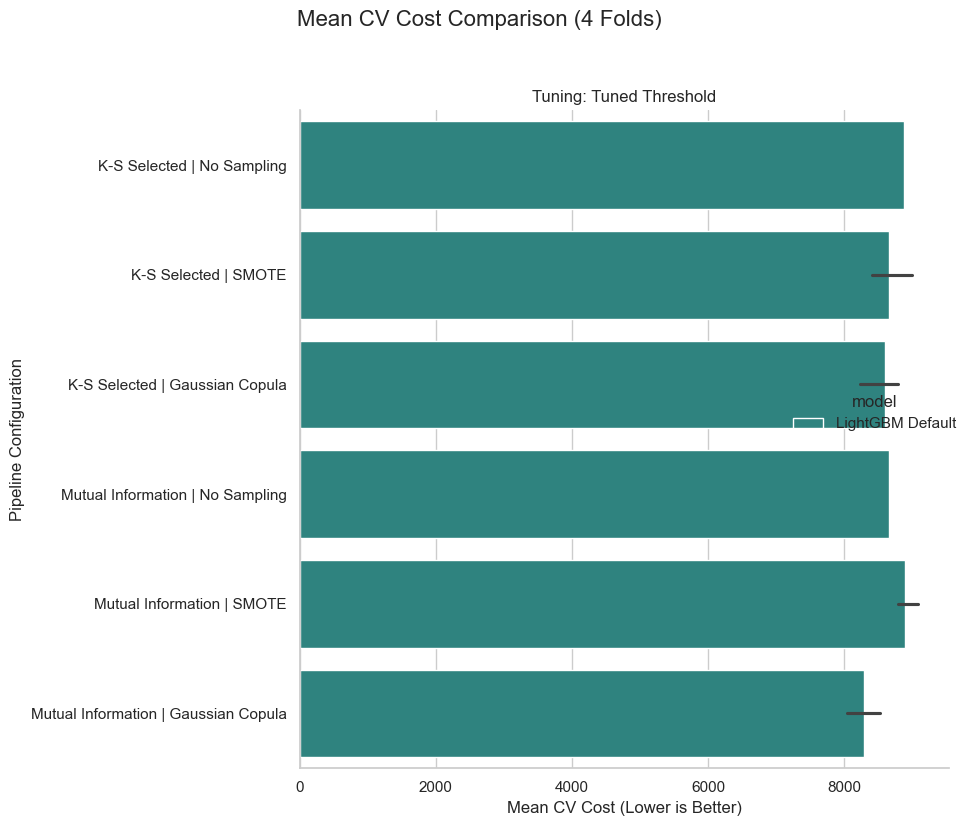

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
%matplotlib inline
sns.set_theme(style="whitegrid")

# --- FIX: Create the 'pipeline_name' column for plotting ---
# We combine 'feature_set' and 'sampler' into one descriptive name
results_df['pipeline_name'] = results_df['feature_set'] + " | " + results_df['sampler']
# --- END FIX ---

print("--- Cross-Validation Results Summary ---")
# Display the full results table, sorted by the most important metric
display(results_df.sort_values(by='cost_mean').reset_index(drop=True))

# --- Visualization ---

print("\n--- Visualizing Experiment Results ---")

# We use 'catplot' to create two separate charts faceted by the 'tuning' column.
g = sns.catplot(
    data=results_df,
    x='cost_mean',      # The metric we want to compare
    y='pipeline_name',  # <-- This will now work
    hue='model',        # Color-code the bars by the model used
    col='tuning',       # Create separate columns for "Tuned" vs. "Fixed 0.5"
    kind='bar',         # Use a bar chart
    palette='viridis',  # Colors
    sharey=False,       # Let the y-axis labels be independent
    height=8,           # Make the plots taller
    aspect=1            # Adjust the aspect ratio
)

# Set titles and labels clearly
g.fig.suptitle(f'Mean CV Cost Comparison ({N_CV_SPLITS} Folds)', y=1.03, fontsize=16)
g.set_axis_labels('Mean CV Cost (Lower is Better)', 'Pipeline Configuration')
g.set_titles("Tuning: {col_name}")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#

In [29]:
# --- CONFIGURE THE WINNING PIPELINE ---
# **Manually update these based on your results from Step 4**

BEST_MODEL_NAME = 'LightGBM Default'  # e.g., 'RandomForest'
BEST_SAMPLER = "copula"      # e.g., 'copula'
BEST_FEATURE_SELECTION = 'K-S Selected'          # e.g., True
BEST_SAMPLING_PERCENTAGE = 0.5
# ---
print(f"--- Running WINNING pipeline on Test Set ---")
print(f"Model: {BEST_MODEL_NAME}")
print(f"Sampler: {BEST_SAMPLER}")
print(f"Sampling Percentage: {BEST_SAMPLING_PERCENTAGE}")
print(f"Feature Selection: {BEST_FEATURE_SELECTION}")

# 1. Get the winning model object
best_model = deepcopy(MODELS_TO_TEST[BEST_MODEL_NAME])

# 2. Select the correct datasets
if BEST_FEATURE_SELECTION=='K-S Selected':
    X_train_data = X_train_ks
    X_test_data = X_test_ks
elif BEST_FEATURE_SELECTION=='Engineered':
    X_train_data = X_train_eng
    X_test_data = X_test_eng
elif BEST_FEATURE_SELECTION=='Engineered + K-S':
    X_train_data = X_train_all
    X_test_data = X_test_all
elif BEST_FEATURE_SELECTION=='Mutual Information':
    X_train_data = X_train_mi
    X_test_data = X_test_mi
else: 
    X_train_data = X_train_raw
    X_test_data = X_test_raw


# 3. Run the final evaluation
# This function handles the tune/refit/evaluate logic automatically
final_run_output = evaluate_on_test(
    best_model,
    X_train_data, y_train_raw,
    X_test_data, y_test_raw,
    sampler=BEST_SAMPLER,
    verbose=True,
    tune_if_none=True,
    sampling_strategy=BEST_SAMPLING_PERCENTAGE,
)

# --- 6. Report Final Metrics ---
final_metrics = final_run_output['metrics']
print("\n--- FINAL TEST SET METRICS ---")
print(f"Total Cost: {final_metrics['Cost']:.0f}")
print(f"AUC: {final_metrics['AUC']:.4f}")
print(f"Macro F1: {final_metrics['MacroF1']:.4f}")
print(f"Recall (pos): {final_metrics['Recall_pos']:.4f}")
print(f"Precision (pos): {final_metrics['Precision_pos']:.4f}")
print(f"Threshold: {final_metrics['Threshold']:.4f}")
print(f"---")
print(f"False Positives (FP): {final_metrics['FP']:.0f} (Cost: {final_metrics['FP'] * 10:.0f})")
print(f"False Negatives (FN): {final_metrics['FN']:.0f} (Cost: {final_metrics['FN'] * 500:.0f})")

--- Running WINNING pipeline on Test Set ---
Model: LightGBM Default
Sampler: copula
Sampling Percentage: 0.5
Feature Selection: K-S Selected
--- Tuning Threshold on Validation Set ---
Balancing: 743 minority, 45758 majority.
Target ratio: 0.5 -> Target minority count: 22879
Synthesizing 22136 samples...
Balancing complete. New dataset size: 68637
[LightGBM] [Info] Number of positive: 22879, number of negative: 45758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33354
[LightGBM] [Info] Number of data points in the train set: 68637, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Threshold tuned in 12.10s -> thr=0.008 (Val Cost=5700)
--- Refitting on Full Train Data & Evaluating Test Set ---
Final fit: Balancing with copula...
Bala


--- Final Test Set Confusion Matrix ---


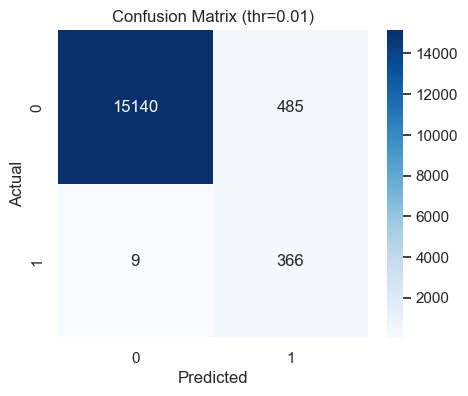

In [30]:
# Plot the final test set confusion matrix
print("\n--- Final Test Set Confusion Matrix ---")

plot_confusion(
    y_test_raw, 
    final_run_output['test_probabilities'], 
    threshold=final_metrics['Threshold']
)
plt.show()